### A/B  тестирование. 


__Дано:__
- данные AB теста
- Даты эксперимента: с 2023-01-31 по 2023-02-06 включительно. 
- Для эксперимента были задействованы 2-я и 1-я группы. В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля. 
- Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR. 

__Задача: проанализировать данные АB-теста.__ 

1. Выбрать метод анализа и сравнить CTR в двух группах.
2. Написать рекомендацию, будем ли мы раскатывать новый алгоритм на всех новых пользователей или все-таки не стоит.

In [1]:
import pandas as pd
import pandahouse as ph
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats

In [2]:
#сразу установим параметры вывода графиков 
sns.set(
    rc={
        "figure.figsize": (12, 8), #размер графика - 12 дюймов в ширину, 8 в длину
        "axes.titlesize": 20, #размер заголовка 
        "axes.labelsize": 14, #размер подписей осей
        "xtick.labelsize": 13, #размер подписей чёрточек на x-оси
        "ytick.labelsize": 13, #размер подписей чёрточек на y-оси
    }
)

In [3]:
connection = {'host': ,
                      'database':,
                      'user':, 
                      'password':
                     }

q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-01-31' and '2023-02-06'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

df = ph.read_clickhouse(q, connection=connection)

df.head()

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,33,122,0.270492
4,1,18392,7,32,0.218750


Посмотрим общее описание по каждой группе

In [4]:
df[df.exp_group == 1].describe()


,exp_group,user_id,likes,views,ctr
count,10079.0,10079.000000,10079.000000,10079.000000,10079.000000
mean,1.0,75540.955948,13.792142,66.299831,0.215605
std,0.0,53211.834816,9.798990,45.043411,0.084160
min,1.0,206.000000,0.000000,2.000000,0.000000
25%,1.0,22227.000000,7.000000,32.000000,0.160097
50%,1.0,109360.000000,12.000000,56.000000,0.203125
75%,1.0,126200.500000,19.000000,90.000000,0.257654
max,1.0,140500.000000,81.000000,311.000000,0.722222


In [5]:
df[df.exp_group == 2].describe()



,exp_group,user_id,likes,views,ctr
count,9952.0,9952.000000,9952.000000,9952.000000,9952.000000
mean,2.0,75142.800543,13.101387,66.148513,0.214419
std,0.0,53315.378033,11.838030,45.151210,0.144180
min,2.0,220.000000,0.000000,1.000000,0.000000
25%,2.0,21904.250000,5.000000,32.000000,0.095238
50%,2.0,109112.500000,9.000000,56.000000,0.142857
75%,2.0,126228.250000,17.000000,91.000000,0.325000
max,2.0,141164.000000,95.000000,321.000000,0.923077


Количество пользователей в группах отличаются на 1.3% . Средние CTR отличаются на 0.001, а вот  медианные на 0.06

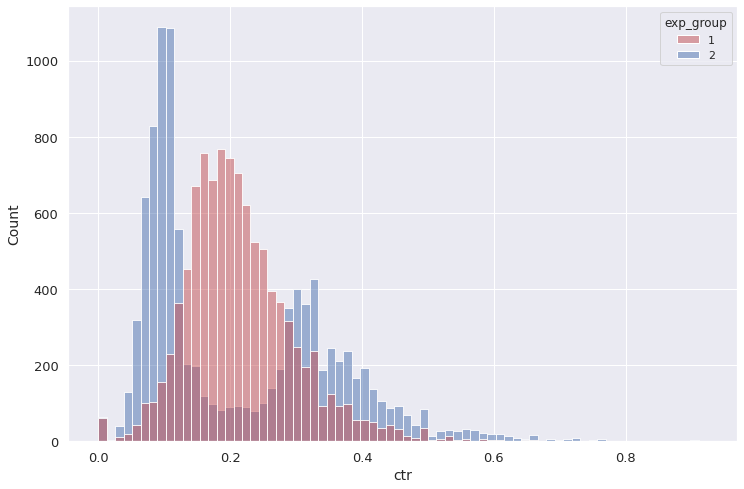

In [6]:
#посмотрим визуально распределение ctr в наших группах
groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

Визуально распределения CTR разные. Если контрольная группа как-то напоминает нормальное распределение, то экспериментальная точно нет: "двугорбое" распределение и как будто пользователи поделились на 2 группы: одна с малыми значениями CTR, а для второй характерны более высокие CTR. 

__Выбор метода анализа__

Исходя из следующих соображений для анализа АВ теста выбираем метод Пуасоновский Бутстреп:
1. Поскольку нас интересует на самом общий показатель CTR  по ВСЕЙ группе
2. Распределение 2торой группы далеко от нормального
3. У нас не слишком много данных, поэтому не смотря на свою "медленность" метод отработает быстро.

In [7]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

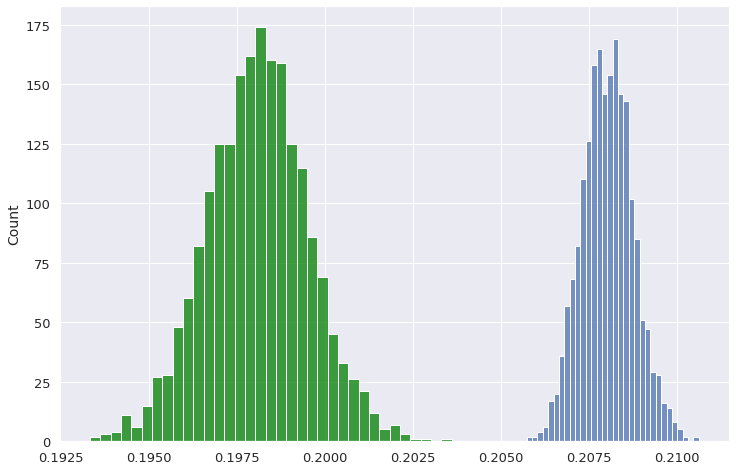

In [8]:
likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

sns.histplot(ctr1)
sns.histplot(ctr2, color = 'green')

plt.show()

Групповой CTR  в экспериментальной группе ниже чем в контрольной.

Построим распределение разницы между "глобальными CTR" двух групп

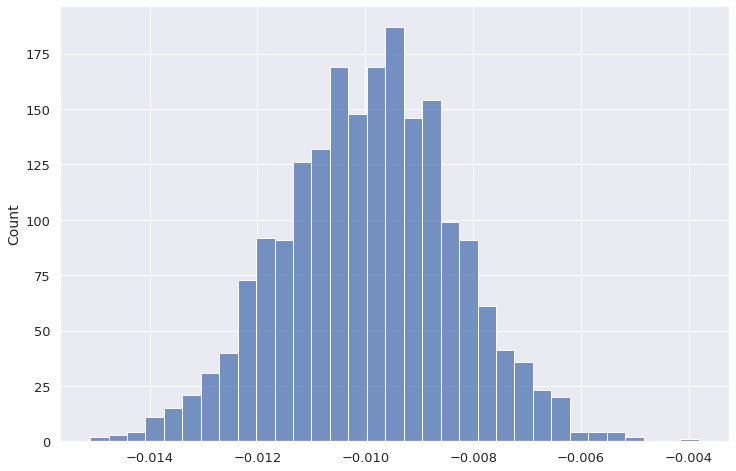

In [9]:
#Разница между глобальными CTR

sns.histplot(ctr2 - ctr1)
plt.show()

Распределение не пересекает 0 и расположено в отрицательных значениях. Это значит, что показатель CTR второй группы  строго меньше первой. 

Распределение CTR второй группы выглядит не характерно для этой метрики. Из распределения CTR второй группы видно, что пользователи как бы разделились на группы, как будто у нас есть два распределения с двумя разными средними. Возможно так и случилось в действительности, было перекрытие с другим тестом, и часть пользователей учавствовала в двух тестах. Да, обычно одновременно запускают только независимые тесты, но может быть была  не корректно сделана оцена зависимости или она неожиданно проявилась. 

### Вывод 

Глобальный CTR 2-й группы (экспериментальной) оказался ниже, чем в контрольной. Из чего следует, что новый алгоритм во 2-й группе привёл к ухудшению. Соответственно раскатывать новый алгоритм на всех новых пользователей не стоит. Может быть стоит проверить корректность проведения AB теста, т.к распределение CTR второй группы выглядит не характерно.